## AIFFEL jupyter notebook 활용

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
# 아직 os.getenv를 사용하여 어떻게 표현해야하는지 모르겠음

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
test.shape

(6468, 20)

# Train 데이터와 Test 데이터를 비교하였을 때 test가 1열 적게 존재한다. Target값 차이

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


* ID : 집을 구분하는 번호
* date : 집을 구매한 날짜
* price : 집의 가격(Target variable)
* bedrooms : 침실의 수
* bathrooms : 화장실의 수
* sqft_living : 주거 공간의 평방 피트(면적)
* sqft_lot : 부지의 평방 피트(면적)
* floors : 집의 층 수
* waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
* view : Has been viewed
* condition : 집의 전반적인 상태
* grade : King County grading 시스템 기준으로 매긴 집의 등급
* sqft_above : 지하실을 제외한 평방 피트(면적)
* sqft_basement : 지하실의 평방 피트(면적)
* yr_built : 지어진 년도
* yr_renovated : 집을 재건축한 년도
* zipcode : 우편번호
* lat : 위도
* long : 경도
* sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
* sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

## 노드에서는 price를 먼저 찢어줬는데, price와 상관관계가 높은 feature를 선별하기 위해 뒤로 미뤄본다.

In [6]:
#일단 target의 분포를 확인해보기
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

## Min과 Max의 차이가 크고 std가 큰편이다. 이를 히스토그램을 통해 확실히 봐야겠다.

<AxesSubplot:xlabel='price', ylabel='Density'>

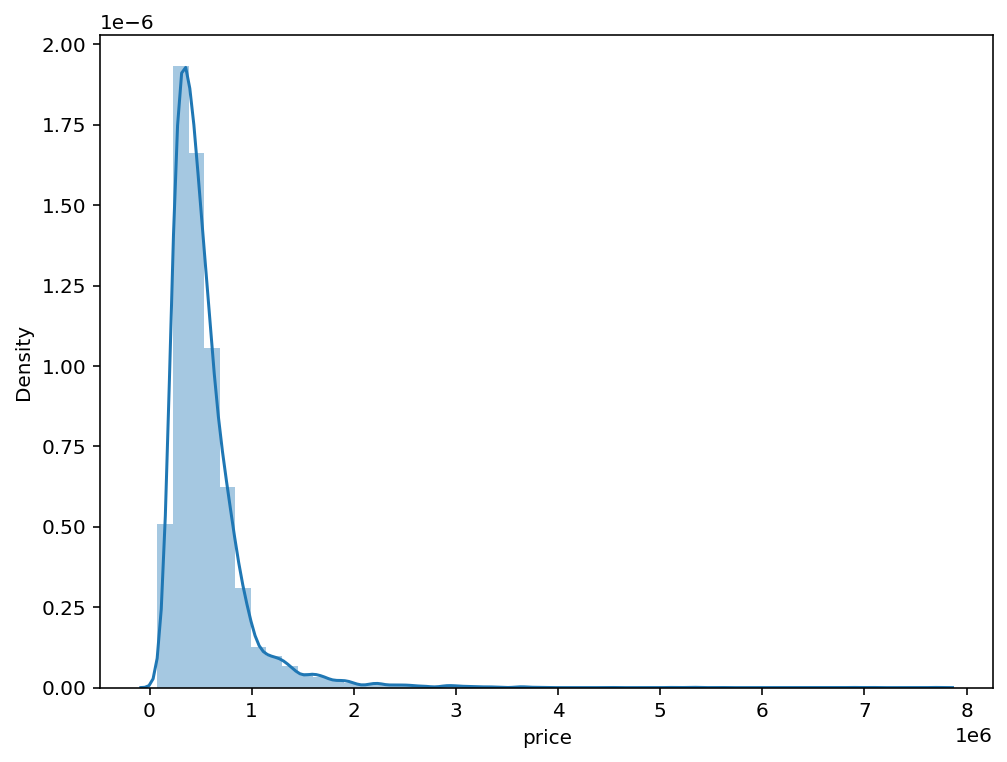

In [7]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

### 노드에서 확인한 것과 같이 왼편으로 치우쳐있는 것을 확인할 수 있다. 이를 log 변환해서 정규분포화 하겠다.

<AxesSubplot:xlabel='price', ylabel='Density'>

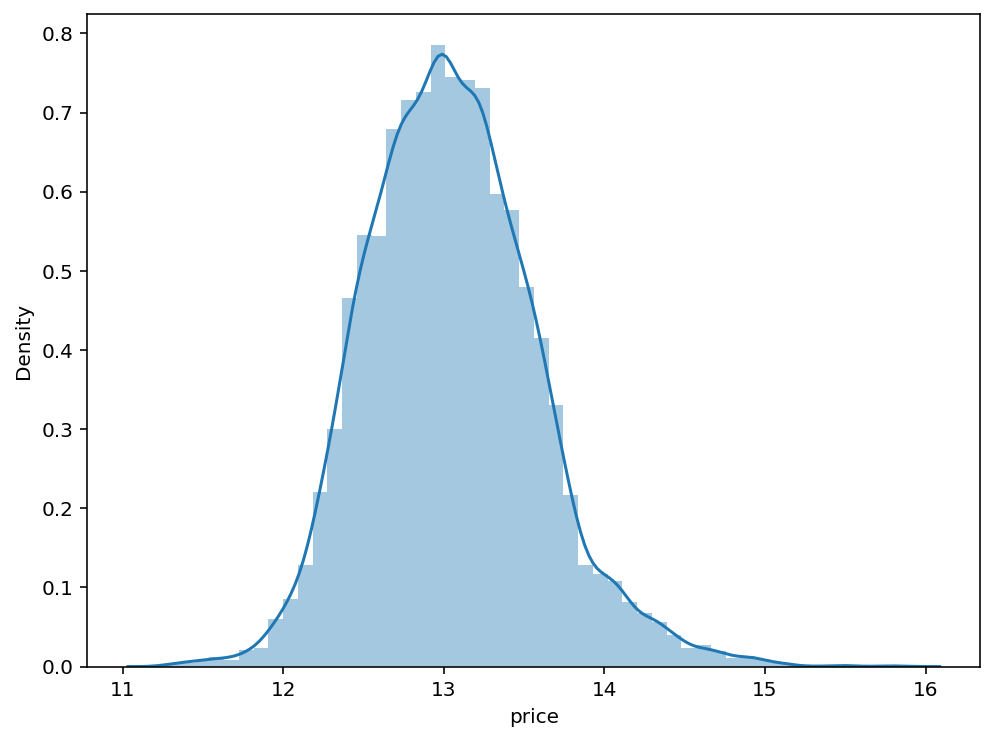

In [8]:
train['price'] = np.log1p(train['price'])

f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

#### 지금 결측치를 한번 확인해 보겠다.

In [9]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

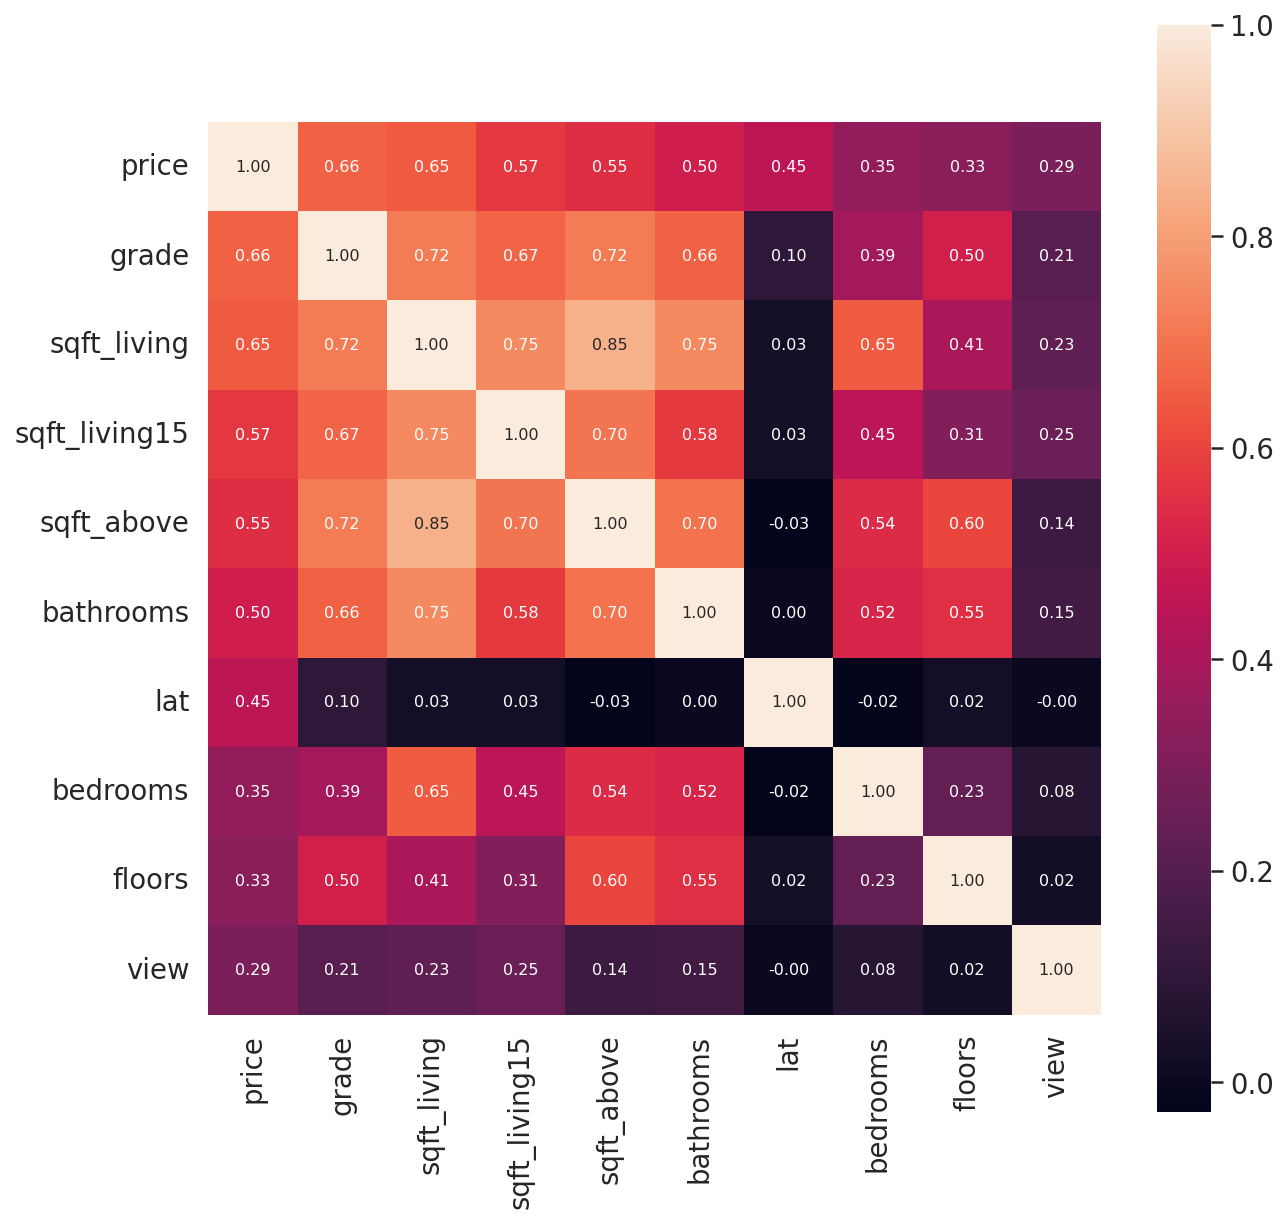

In [10]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

# Target과 연관도가 높은 10개의 feature를 확인하기 위해 heatmap을 그렸다. 인터넷을 참고하여 coding하였다.

## 순서는 grade > sqft_living > sqft_living15 > sqft_above > bathrooms > lat > bedrooms > floors 순으로 연관도가 높았다.

## 이 이후로 EDA를 통해 어떠한 처리를 하면 좋을 것 같지만, 아직 실력이 부족하여 node 내용을 기반으로 그냥 진행하겠다.

In [11]:
y =train['price']

del train['price']

In [12]:
train_len = len(train)
train = pd.concat((train, test), axis=0)

print(len(train))

21503


In [13]:
sub_id = train['id'][train_len:]
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
train['date'] = train['date'].apply(lambda x : str(x[:6]))

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [15]:
train['date'] = train['date'].apply(lambda x: int(x[:6]))

In [16]:
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

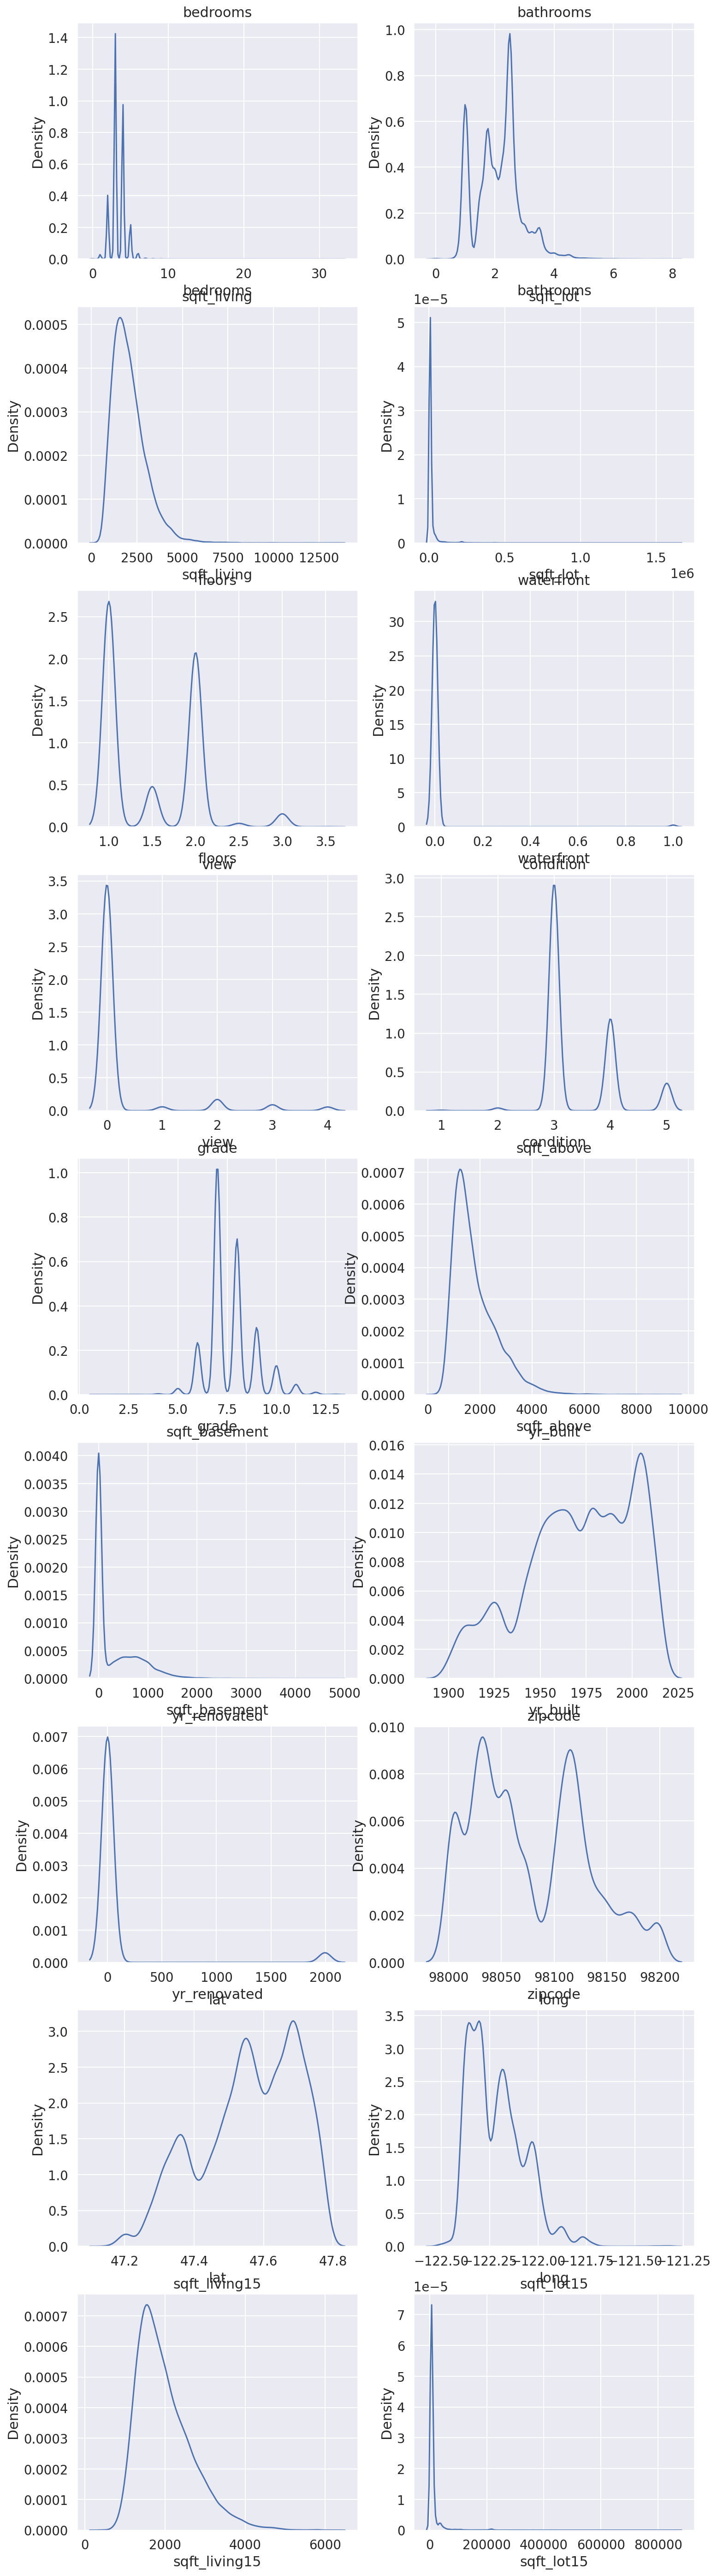

In [17]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [18]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

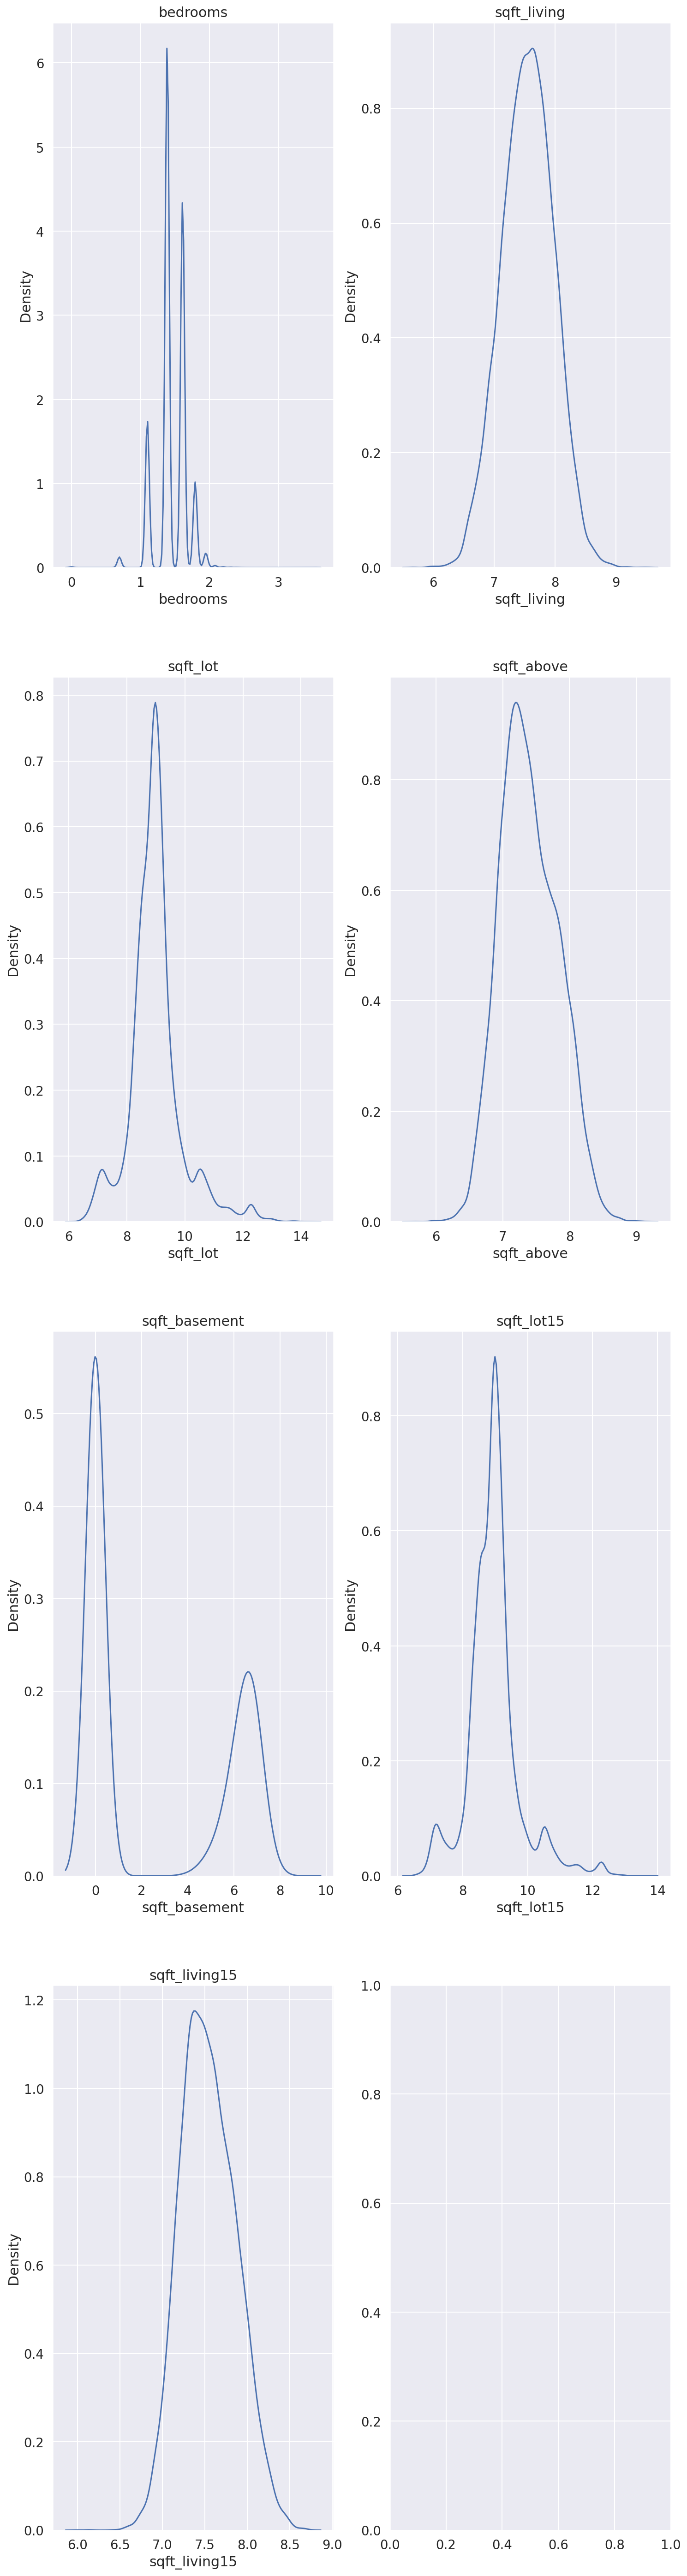

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == len(skew_columns) :
            break

## date 바꾸고 이것 저것 확인해본 다음 이제 다시 test train 찢어준다

In [20]:
test = train.iloc[train_len:, :]
train = train.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


In [21]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [22]:
def get_scores(models, x, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [23]:
def my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                                cv=5, verbose=1, n_jobs=5)

    grid_model.fit(x, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE', ascending=True)

    return results

In [24]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = ('~/aiffel/Ex02_KaKR/')
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [25]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

In [26]:
#save_submission(model,train, y, test, 'lgbm', rmsle='0.164399')

### 위에 코드를 실행하면 계속 에러가남... prediction과 submission의 길이가 다르다는 에러

In [27]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
grid_model.cv_results_

{'mean_fit_time': array([0.56010222, 0.5644896 , 1.1065619 , 1.67355571]),
 'std_fit_time': array([0.03051894, 0.09097422, 0.1335005 , 0.28019841]),
 'mean_score_time': array([0.03242068, 0.05049758, 0.06286931, 0.05660114]),
 'std_score_time': array([0.0162925 , 0.00953568, 0.02630081, 0.03123707]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885212, -0.02664578]),
 'split1_test_score': array([-0.07666447, -0.05787771, -0.03041421, -0.02795768]),
 'split2_test_score': array([-0.07354904

In [29]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [31]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339763, -0.05502353, -0.02917395, -0.02702438])

In [32]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073398
1,1,100,-0.055024
2,10,50,-0.029174
3,10,100,-0.027024


In [33]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073398,0.270920
1,1,100,-0.055024,0.234571
2,10,50,-0.029174,0.170804
3,10,100,-0.027024,0.164391


In [34]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073398,0.270920
1,1,100,-0.055024,0.234571
2,10,50,-0.029174,0.170804
3,10,100,-0.027024,0.164391


In [35]:
results = results.sort_values('RMSLE', ascending=True)
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164391
2,10,50,-0.029174,0.170804
1,1,100,-0.055024,0.234571
0,1,50,-0.073398,0.270920


In [36]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                                cv=5, verbose=1, n_jobs=5)

    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE', ascending=True)

    return results

param_grid = {
    'n_estimators': [300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400],
    'max_depth': [10, 11],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

In [37]:
model = LGBMRegressor(max_depth=10, n_estimators=370, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.17748795, 13.07939778, 14.10015971, ..., 13.05438716,
       12.71085635, 12.99724343])

In [38]:
prediction = np.expm1(prediction)
prediction

array([ 528335.11976112,  478971.17149554, 1329294.56534891, ...,
        467140.34585237,  331324.43345119,  441194.52822288])

In [40]:
data_dir =  os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
#prediction = prediction[:len(submission)]

In [41]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.283351e+05
1,15036,4.789712e+05
2,15037,1.329295e+06
3,15038,2.956962e+05
4,15039,3.326237e+05


In [42]:
submission_csv_path = '{}/submission_{}_RMSLE_{}_re.csv'.format(data_dir, 'lgbm', '0.161517')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161517_re.csv


# 분명히 아이펠 노드 그대로 따라했을 때에는 Private Score이 116130이 나왔지만, 위의 코드를 실행하니 487257이 나왔다. 

# 무엇이 문제인지 알 수 없어서 너무 답답하다... 일단은 이대로 제출을 하고 수정해봐야할 것 같다.

# 형철님 도움으로 다시 점수가 나왔다. 110400

### 해결되지 못한 issue:

* test data의 length는 총 6555개이고, submission data의 length는 6468개 이다. 그러면, data의 개수가 맞지 않는데 이것은 어떻게 해결해야하는것인가?
* 위의 코드들은 노드와 똑같이 수행했음에도 불구하고 왜 점수가 다르게 나오고 에러가 발생하는 것일까?
* 제가 그냥 뭔가 test를 잘못 건드렸나봅니다...ㅎㅎ

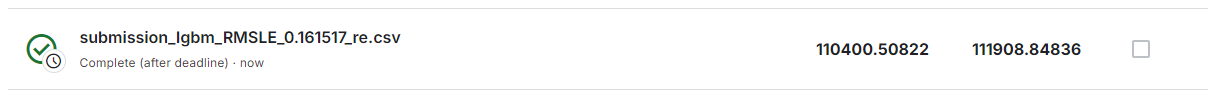